# 06 Motif Annotation
<b>Bart Theeuwes </b>

First we identify the motifs that are present in each peak. Next, ChromVAR is used to identify transcription-factor-associated accessibility.

In [1]:
here::i_am("01_create_arrow.R")
source(here::here("settings.R"))
source(here::here("load_archr.R"))

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/code

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==

### Motif enrichment

In [2]:
addArchRThreads(30)

Setting default number of Parallel threads to 30.



In [3]:
# Motif enrichment
ArchRProject <- addMotifAnnotations(ArchRProj = ArchRProject, motifSet = "cisbp", name = "Motif", species='Homo sapiens', force=TRUE)

Using version 2 motifs!



In [4]:
ArchRProject <- addBgdPeaks(ArchRProject, method='chromVAR') # method ArchR bc of error ?

Identifying Background Peaks!



In [5]:
ArchRProject <- addDeviationsMatrix(
  ArchRProj = ArchRProject, 
  peakAnnotation = "Motif",
  force = TRUE
)
saveArchRProject(ArchRProj = ArchRProject)

Using Previous Background Peaks!



NULL


Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project 
samples(8): rabbit_BGRGP1 rabbit_BGRGP2 ... rabbit_BGRGP7 rabbit_BGRGP8
sampleColData names(1): ArrowFiles
cellColData names(24): Sample TSSEnrichment ... stage_clusters cell
numberOfCells(1): 34082
medianTSS(1): 3.615
medianFrags(1): 33602

### Identification of Positive TF-Regulators

In [6]:
library(ggrepel)

In [7]:
seGroupMotif <- getGroupSE(ArchRProj = ArchRProject, useMatrix = "MotifMatrix", groupBy = "Clusters_PeakMatrix")
seZ <- seGroupMotif[rowData(seGroupMotif)$seqnames=="z",]

In [8]:
rowData(seZ)$maxDelta <- lapply(seq_len(ncol(seZ)), function(x){
  rowMaxs(assay(seZ) - assay(seZ)[,x])
}) %>% Reduce("cbind", .) %>% rowMaxs

In [9]:
# GeneScoreMatrix
corGSM_MM <- correlateMatrices(
    ArchRProj = ArchRProject,
    useMatrix1 = "GeneScoreMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "PeakMatrix"
)

corGSM_MM$maxDelta <- rowData(seZ)[match(corGSM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]
corGSM_MM$TFRegulator <- "NO"
corGSM_MM$TFRegulator[which(corGSM_MM$cor > 0.5 & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.75))] <- "YES"
sort(corGSM_MM[corGSM_MM$TFRegulator=="YES",1])

2022-04-29 11:55:08 : SuppressedMessaged due to getArchRVerbose() is FALSE!



[1] "CDX1"   "CDX4"   "CEBPA"  "ELK1"   "FOS"    "FOSL2"  "FOXA2"  "GATA3" 
 [9] "HNF1B"  "HOXA4"  "HOXA9"  "HOXB1"  "HOXB9"  "HOXC11" "ISX"    "LHX9"  
[17] "MITF"   "NFYA"   "POU3F4" "POU6F2" "RFX3"   "RFX4"   "SOX13"  "TEAD1" 
[25] "TEAD4"  "TFAP2A" "TP63"

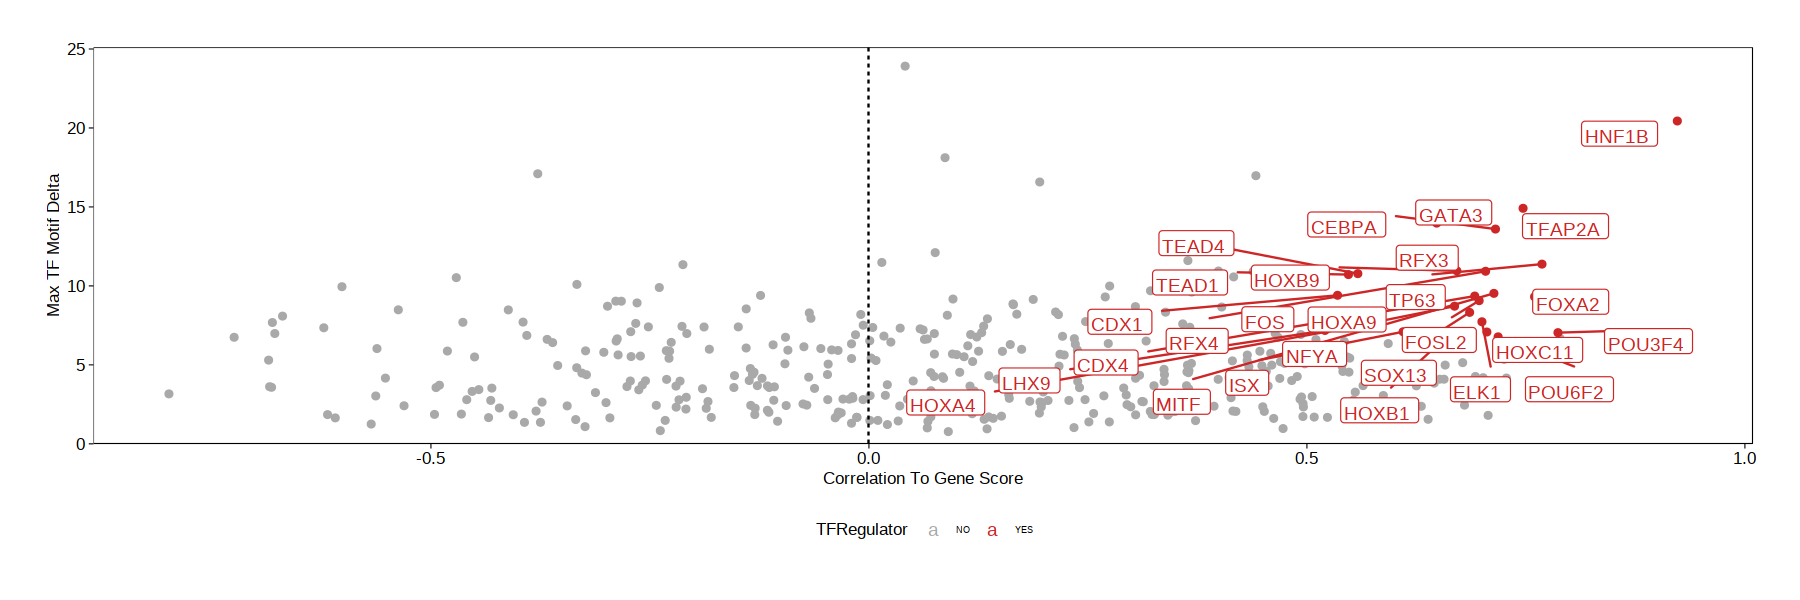

In [10]:
p <- ggplot(data.frame(corGSM_MM), aes(cor, maxDelta, color = TFRegulator, label=GeneScoreMatrix_name)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGSM_MM$maxDelta)*1.05))  +
  geom_label_repel(data=data.frame(corGSM_MM)[data.frame(corGSM_MM)$TFRegulator=='YES',], 
                    max.overlaps=Inf,
                    box.padding = 0.3, hjust=0, vjust=0)

p

In [11]:
# GeneIntegrationMatrix
corGIM_MM <- correlateMatrices(
    ArchRProj = ArchRProject,
    useMatrix1 = "GeneIntegrationMatrix_PeakMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "PeakMatrix"
)

corGIM_MM$maxDelta <- rowData(seZ)[match(corGIM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

corGIM_MM <- corGIM_MM[order(abs(corGIM_MM$cor), decreasing = TRUE), ]
corGIM_MM <- corGIM_MM[which(!duplicated(gsub("\\-.*","",corGIM_MM[,"MotifMatrix_name"]))), ]
corGIM_MM$TFRegulator <- "NO"
corGIM_MM$TFRegulator[which(corGIM_MM$cor > 0.5 & corGIM_MM$padj < 0.01 & corGIM_MM$maxDelta > quantile(corGIM_MM$maxDelta, 0.75))] <- "YES"
sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",1])

2022-04-29 11:55:43 : SuppressedMessaged due to getArchRVerbose() is FALSE!



[1] "CDX4"   "CEBPA"  "FLI1"   "FOXA2"  "GATA3"  "HNF1B"  "HNF4G"  "HOXA11"
 [9] "HOXA13" "HOXA9"  "HOXB1"  "HOXB8"  "HOXB9"  "HOXC11" "HOXD11" "MITF"  
[17] "POU2F1" "POU5F1" "RFX3"   "RFX4"   "RFX7"   "TEAD4"  "TFAP2A" "TP63"  
[25] "ZNF219"

Warning message:
“Removed 14 rows containing missing values (geom_point).”


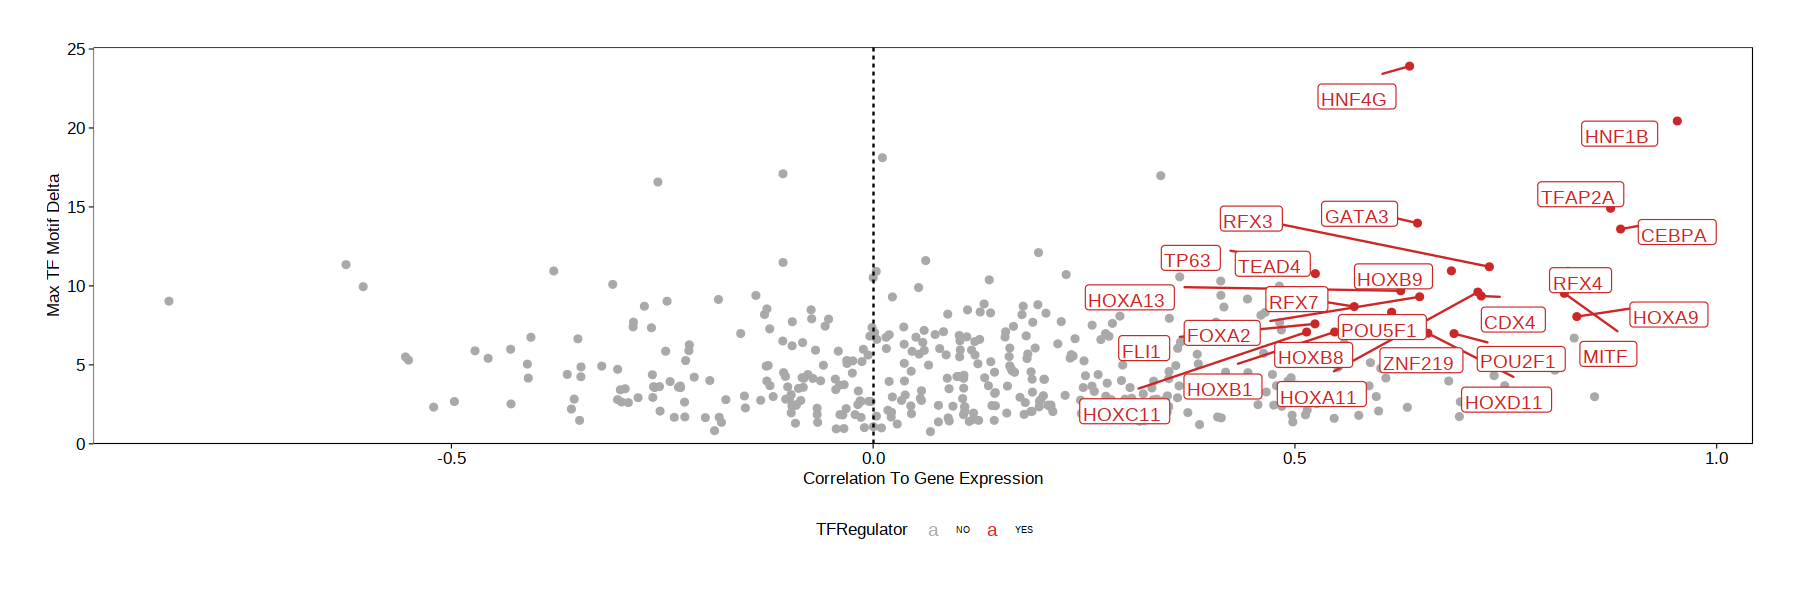

In [12]:
p <- ggplot(data.frame(corGIM_MM), aes(cor, maxDelta, color = TFRegulator,, label=GeneIntegrationMatrix_PeakMatrix_name)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Expression") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGIM_MM$maxDelta)*1.05)) +
  geom_label_repel(data=data.frame(corGIM_MM)[data.frame(corGIM_MM)$TFRegulator=='YES',], 
                    max.overlaps=Inf,
                    box.padding = 0.3, hjust=0, vjust=0)

p